In [1]:
# import sys
# sys.path.append('../')

import numpy as np
import pandas as pd
from Hypervolume import HyperVolume
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

font = {'size': 16}
plt.rc('font', **font)

In [2]:
def plot_pf(non_dominated_points, rep, ax, l="", legend_uncertainty=True):
    
    m = non_dominated_points #np.mean(rep, axis=1)
    std =  np.sqrt(np.var(rep, axis=1))
    max_data = m+std #np.max(non_dominated_points, axis=1)
    min_data = m-std #np.min(non_dominated_points, axis=1)
    
    ells = [Ellipse(xy=[m[i,0], m[i,1]], 
                    width=np.abs(max_data[i,0]-min_data[i,0]), 
                    height=np.abs(max_data[i,1]-min_data[i,1]))
            for i in range(m.shape[0])]

    index = 0
    for e in ells:
        ax.add_patch(e)
        
        if index==0 and legend_uncertainty:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor="peachpuff", edgecolor='silver', label=r'Uncertainty ($mean \pm std$)')
        else:
            e.set(clip_box=ax.bbox, alpha=0.2, facecolor="peachpuff", edgecolor='silver')
        index+=1
        
#         e.set_edgecolor('silver')
#     max_axes = np.max([max_data[:,0], max_data[:,1]])
#     ax.set_xlim(0, max_axes+.5)
#     ax.set_ylim(0, max_axes+.5)

    ax.scatter(non_dominated_points[:, 0], non_dominated_points[:, 1], s=50, 
               label="Observed PF "+l)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    
#     ax.scatter(tf[:,0], tf[:,1], label="Optimal PF")
#     ax.scatter(solutions[:, 0], solutions[:, 1], color='orange', marker='+', zorder=len(ells)+2, label="Solutions")
    return ax

In [3]:
def compute_hypervolume(m, referencePoint):
    hv = HyperVolume(referencePoint)
    volume = hv.compute(m)
    return volume

In [4]:
def pareto_front(points, level=0, index=False):

    points = points.copy()
    ranks = np.zeros(len(points))
    r = 0
    c = len(points)
    while c > 0:
        extended = np.tile(points, (points.shape[0], 1, 1))
        dominance = np.sum(np.logical_and(
            np.all(extended <= np.swapaxes(extended, 0, 1), axis=2),
            np.any(extended < np.swapaxes(extended, 0, 1), axis=2)), axis=1)
        points[dominance == 0] = 1e9  # mark as used
        ranks[dominance == 0] = r
        r += 1
        c -= np.sum(dominance == 0)
    if index:
#         return ranks
        return [i for i in range(len(ranks)) if ranks[i] == level] 
    else:    
        ind = [i for i in range(len(ranks)) if ranks[i] == level]
        return points[ind]

In [5]:
def plot_hypervolumen(file_name, initial_point, gp, motpe, gp_motpe, ref_point):
    
    hv_gp = []
    hv_motpe = []
    hv_gp_motpe = []
    for index in range(initial_point, gp.shape[0]):
        pf = pareto_front(gp[:index], index=True)
        pf = gp[pf]
        volumen = compute_hypervolume(pf, ref_point)
        hv_gp.append(volumen)
        
        pf = pareto_front(motpe[:index], index=True)
        pf = motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        hv_motpe.append(volumen)
        
        pf = pareto_front(gp_motpe[:index], index=True)
        pf = gp_motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        hv_gp_motpe.append(volumen)
        
    print(file_name, hv_gp[-1], hv_motpe[-1], hv_gp_motpe[-1])
#     print(hv_gp)
    fig, ax = plt.subplots(figsize=(7,7))
    ax.plot(hv_gp, label="GP")
    ax.plot(hv_motpe, label="MOTPE")
    ax.plot(hv_gp_motpe, label="GP_MOTPE")
    ax.set_xlabel("Iterations (Number of infill points)")
    ax.set_ylabel("Hypervolumen")
    plt.legend(loc="lower right")
    plt.savefig(file_name, dpi=1200, bbox_inches='tight')

In [6]:
def plot_function(file_name, gp, motpe, gp_motpe, rgp, rmotpe, rgp_motpe, tpf=[], xlim=[0, 1], ylim=[0,1], plot_uncertainty=True):
    pf_gp = pareto_front(gp, index=True)
    rpf_gp = rgp[pf_gp]
    pf_gp = gp[pf_gp]
    
    pf_motpe = pareto_front(motpe, index=True)
    rpf_motpe = rmotpe[pf_motpe]
    pf_motpe = motpe[pf_motpe]
    
    pf_gp_motpe = pareto_front(gp_motpe, index=True)
    rpf_gp_motpe = rgp_motpe[pf_gp_motpe]
    pf_gp_motpe = gp_motpe[pf_gp_motpe]
    
    
    fig, ax = plt.subplots(figsize=(7,7))
    if len(tpf)!=0:
        ax.scatter(tpf[:,0], tpf[:,1], color='k', s=5, label="True PF")
    ax = plot_pf(pf_gp, rpf_gp, ax, l="GP", legend_uncertainty=plot_uncertainty)
    ax = plot_pf(pf_motpe, rpf_motpe, ax, l="MOTPE", legend_uncertainty=False)
    ax = plot_pf(pf_gp_motpe, rpf_gp_motpe, ax, l="GP_MOTPE", legend_uncertainty=False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc='upper right')
    plt.savefig(file_name, dpi=1200, bbox_inches='tight')

In [7]:
# Load true PF
ZDT1 = pd.read_csv("PF_data\PF_functions\ZDT1.csv", sep=',', header=0).values
DTLZ6 = pd.read_csv("PF_data\PF_functions\DTLZ6.csv", sep=',', header=0).values
DTLZ7 = pd.read_csv("PF_data\PF_functions\DTLZ7.csv", sep=',', header=0).values
WFG4 = pd.read_csv("PF_data\PF_functions\WFG4.csv", sep=',', header=0).values

## Pareto front visualization

In [40]:
# load data exploration
WFG4_motpe_01 = pd.read_csv("PF_data\exploration_noisy_MOTPE_WFG4.csv", sep=',', header=0).values[:,1:]
WFG4_gp_01 = pd.read_csv("PF_data\exploration_GP_WFG4.csv", sep=',', header=0).values[:,1:]
WFG4_gp_motpe_01 = pd.read_csv("PF_data\exploration_GP_MOTPE_WFG4.csv", sep=',', header=0).values[:,1:]
WFG4_gp_motpe_01_ns = pd.read_csv("PF_data\exploration_GP_MOTPE_WFG4_0.1_ns.csv", sep=',', header=0).values[:,1:]


# Load the other gammas
dict_motpe_gamma = {}
dict_gp_motpe_gamma = {}
dict_gp_motpe_gamma_ns = {}
gammas = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for g in gammas:
    dict_motpe_gamma["motpe_"+str(g)] = pd.read_csv("PF_data\exploration_noisy_MOTPE_WFG4_"+str(g)+".csv", sep=',', header=0).values[:,1:]
    dict_gp_motpe_gamma["gp_motpe_"+str(g)] = pd.read_csv("PF_data\exploration_GP_MOTPE_WFG4_"+str(g)+".csv", sep=',', header=0).values[:,1:]
    dict_gp_motpe_gamma_ns["gp_motpe_ns_"+str(g)] = pd.read_csv("PF_data\exploration_GP_MOTPE_WFG4_"+str(g)+"_ns.csv", sep=',', header=0).values[:,1:]
    
    

## Comparing gamma for MOTPE and GP_MOTPE

6.698531935229314 7.960440060717553 7.422126605040488


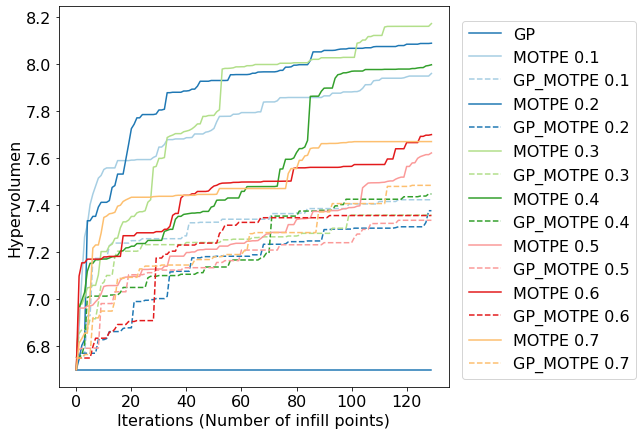

In [39]:
initial_point = 54

gp=WFG4_gp_01
motpe=WFG4_motpe_01
gp_motpe=WFG4_gp_motpe_01
ref_point=[3, 5]


hv_gp = []
hv_motpe = []
hv_gp_motpe = []
for index in range(initial_point, gp.shape[0]):
    pf = pareto_front(gp[:index], index=True)
    pf = gp[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp.append(volumen)

    pf = pareto_front(motpe[:index], index=True)
    pf = motpe[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_motpe.append(volumen)

    pf = pareto_front(gp_motpe[:index], index=True)
    pf = gp_motpe[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp_motpe.append(volumen)

print(hv_gp[-1], hv_motpe[-1], hv_gp_motpe[-1])
#     print(hv_gp)
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(hv_gp, label="GP")
ax.plot(hv_motpe, color=plt.cm.Paired(0), label="MOTPE 0.1")
ax.plot(hv_gp_motpe, "--", color=plt.cm.Paired(0), label="GP_MOTPE 0.1")
ax.set_xlabel("Iterations (Number of infill points)")
ax.set_ylabel("Hypervolumen")

for g in gammas:
    motpe=dict_motpe_gamma["motpe_"+str(g)]
    gp_motpe=dict_gp_motpe_gamma["gp_motpe_"+str(g)]
    
    temp_motpe = []
    temp_gp_motpe = []
    for index in range(initial_point, gp.shape[0]):
        pf = pareto_front(motpe[:index], index=True)
        pf = motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        temp_motpe.append(volumen)
        
        pf = pareto_front(gp_motpe[:index], index=True)
        pf = gp_motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        temp_gp_motpe.append(volumen)
        
    ax.plot(temp_motpe, color=plt.cm.Paired(int(g*10-1)), label="MOTPE "+str(g))
    ax.plot(temp_gp_motpe, "--", color=plt.cm.Paired(int(g*10-1)), label="GP_MOTPE "+str(g))

plt.legend(loc="lower right", bbox_to_anchor=(1.5, 0))

## Comparing gamma for GP_MOTPE and GP_MOTPE_ns

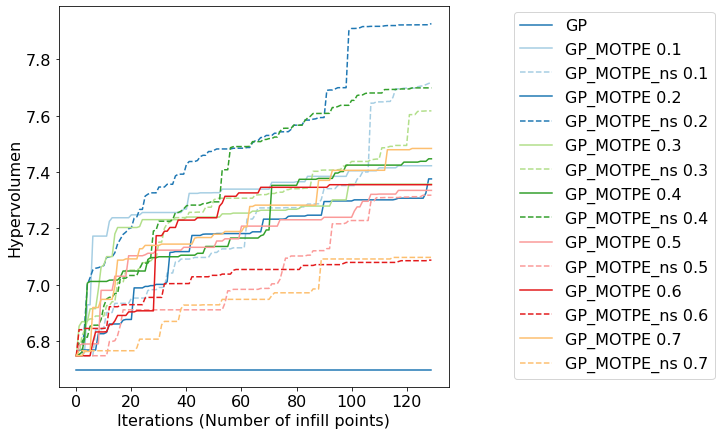

In [42]:
initial_point = 54

gp=WFG4_gp_01
gp_motpe=WFG4_gp_motpe_01
gp_motpe_ns=WFG4_gp_motpe_01_ns
ref_point=[3, 5]


hv_gp = []
hv_gp_motpe = []
hv_gp_motpe_ns = []
for index in range(initial_point, gp.shape[0]):
    pf = pareto_front(gp[:index], index=True)
    pf = gp[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp.append(volumen)

    pf = pareto_front(gp_motpe[:index], index=True)
    pf = gp_motpe[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp_motpe.append(volumen)

    pf = pareto_front(gp_motpe_ns[:index], index=True)
    pf = gp_motpe_ns[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp_motpe_ns.append(volumen)

    
    
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(hv_gp, label="GP")
ax.plot(hv_gp_motpe, color=plt.cm.Paired(0), label="GP_MOTPE 0.1")
ax.plot(hv_gp_motpe_ns, "--", color=plt.cm.Paired(0), label="GP_MOTPE_ns 0.1")
ax.set_xlabel("Iterations (Number of infill points)")
ax.set_ylabel("Hypervolumen")

for g in gammas:
    gp_motpe=dict_gp_motpe_gamma["gp_motpe_"+str(g)]
    gp_motpe_ns=dict_gp_motpe_gamma_ns["gp_motpe_ns_"+str(g)]
    
    temp_gp_motpe = []
    temp_gp_motpe_ns = []
    for index in range(initial_point, gp.shape[0]):
        pf = pareto_front(gp_motpe[:index], index=True)
        pf = gp_motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        temp_gp_motpe.append(volumen)

        pf = pareto_front(gp_motpe_ns[:index], index=True)
        pf = gp_motpe_ns[pf]
        volumen = compute_hypervolume(pf, ref_point)
        temp_gp_motpe_ns.append(volumen)
        
    ax.plot(temp_gp_motpe, color=plt.cm.Paired(int(g*10-1)), label="GP_MOTPE "+str(g))
    ax.plot(temp_gp_motpe_ns, "--", color=plt.cm.Paired(int(g*10-1)), label="GP_MOTPE_ns "+str(g))

plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0))

## Comparing gamma for MOTPE and GP_MOTPE_ns (gamma=l)


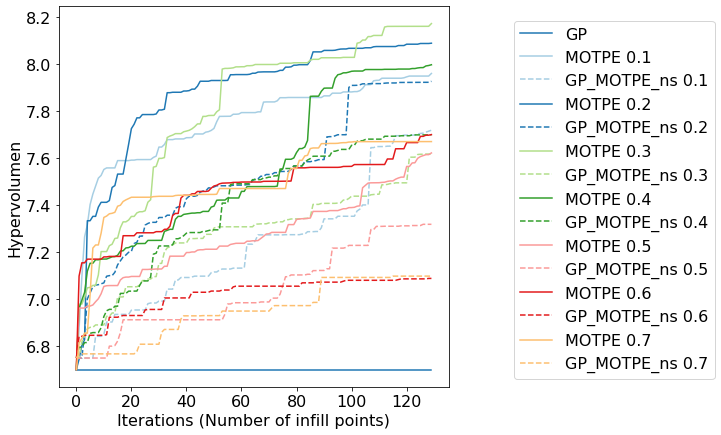

In [43]:
initial_point = 54

gp=WFG4_gp_01
motpe=WFG4_motpe_01
gp_motpe_ns=WFG4_gp_motpe_01_ns
ref_point=[3, 5]


hv_gp = []
hv_motpe = []
hv_gp_motpe_ns = []
for index in range(initial_point, gp.shape[0]):
    pf = pareto_front(gp[:index], index=True)
    pf = gp[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp.append(volumen)

    pf = pareto_front(motpe[:index], index=True)
    pf = motpe[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_motpe.append(volumen)

    pf = pareto_front(gp_motpe_ns[:index], index=True)
    pf = gp_motpe_ns[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp_motpe_ns.append(volumen)

    
    
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(hv_gp, label="GP")
ax.plot(hv_motpe, color=plt.cm.Paired(0), label="MOTPE 0.1")
ax.plot(hv_gp_motpe_ns, "--", color=plt.cm.Paired(0), label="GP_MOTPE_ns 0.1")
ax.set_xlabel("Iterations (Number of infill points)")
ax.set_ylabel("Hypervolumen")

for g in gammas:
    motpe=dict_motpe_gamma["motpe_"+str(g)]
    gp_motpe_ns=dict_gp_motpe_gamma_ns["gp_motpe_ns_"+str(g)]
    
    temp_motpe = []
    temp_gp_motpe_ns = []
    for index in range(initial_point, gp.shape[0]):
        pf = pareto_front(motpe[:index], index=True)
        pf = motpe[pf]
        volumen = compute_hypervolume(pf, ref_point)
        temp_motpe.append(volumen)

        pf = pareto_front(gp_motpe_ns[:index], index=True)
        pf = gp_motpe_ns[pf]
        volumen = compute_hypervolume(pf, ref_point)
        temp_gp_motpe_ns.append(volumen)
        
    ax.plot(temp_motpe, color=plt.cm.Paired(int(g*10-1)), label="MOTPE "+str(g))
    ax.plot(temp_gp_motpe_ns, "--", color=plt.cm.Paired(int(g*10-1)), label="GP_MOTPE_ns "+str(g))

plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0))

## Comparing gamma and lambda for GP_MOTPE_ns

In [90]:
lambdas = np.linspace(0.01, 0.1, 10)
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
ref_point=[3, 5]

# Load gammas and l results
dict_gl = {}
hv_matrix = np.zeros((len(lambdas), len(gammas)))

i = 0
for l in lambdas:
    j = 0
    for g in gammas:
        file_name = "PF_data\exploration_GP_MOTPE_WFG4_"+str(g)+"_l_"+str(np.round(l,2))+".csv"
#         print(file_name)
        print(str(i)+str(j), " ", end = '')
        data = pd.read_csv(file_name, sep=',', header=0).values[:,1:]
        dict_gl[str(g)+"_"+str(np.round(l,2))] = data
        
        pf = pareto_front(data, index=True)
        pf = data[pf]
        volumen = compute_hypervolume(pf, ref_point)
        hv_matrix[i,j] = volumen
    
        j+=1
    print()
    i+=1

00  01  02  03  04  05  06  
10  11  12  13  14  15  16  
20  21  22  23  24  25  26  
30  31  32  33  34  35  36  
40  41  42  43  44  45  46  
50  51  52  53  54  55  56  
60  61  62  63  64  65  66  
70  71  72  73  74  75  76  
80  81  82  83  84  85  86  
90  91  92  93  94  95  96  


Text(64.0, 0.5, 'lambda')

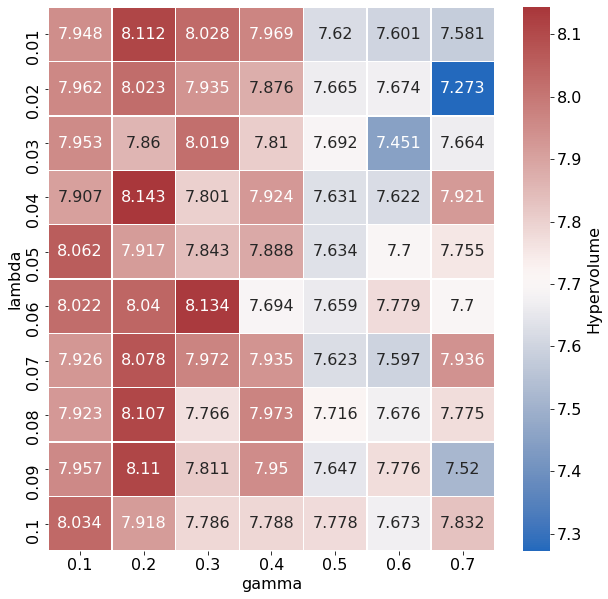

In [87]:
import seaborn as sns

fig, axn = plt.subplots(figsize=(10,10))
g4 = sns.heatmap(hv_matrix, linewidth = 0.5 , cmap = 'vlag', annot=True, fmt=".4", 
                 cbar_kws={'label': 'Hypervolume'}, ax=axn)
g4.set_xticklabels(list(map(str,gammas)))
g4.set_yticklabels([str(np.round(l,2)) for l in lambdas])
g4.set_xlabel("gamma")
g4.set_ylabel("lambda")

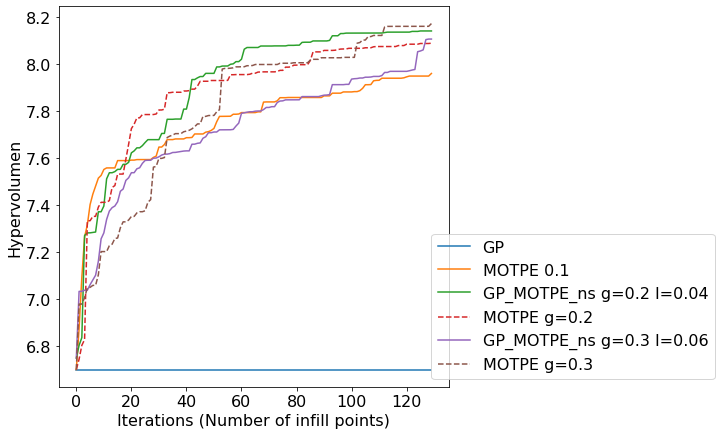

In [99]:
initial_point = 54

gp=WFG4_gp_01
motpe=WFG4_motpe_01
gp_motpe_ns=dict_gl["0.2_0.04"]
gp_motpe_ns_03=dict_gl["0.3_0.06"]

motpe_02 = dict_motpe_gamma["motpe_"+str(0.2)]
motpe_03 = dict_motpe_gamma["motpe_"+str(0.3)]

ref_point=[3, 5]


hv_gp = []
hv_motpe = []
hv_gp_motpe_ns = []
hv_gp_motpe_ns_03 = []

hv_motpe_02 = []
hv_motpe_03 = []

for index in range(initial_point, gp.shape[0]):
    pf = pareto_front(gp[:index], index=True)
    pf = gp[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp.append(volumen)

    pf = pareto_front(motpe[:index], index=True)
    pf = motpe[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_motpe.append(volumen)

    pf = pareto_front(gp_motpe_ns[:index], index=True)
    pf = gp_motpe_ns[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp_motpe_ns.append(volumen)
    
    pf = pareto_front(motpe_02[:index], index=True)
    pf = motpe_02[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_motpe_02.append(volumen)
    
    pf = pareto_front(motpe_03[:index], index=True)
    pf = motpe_03[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_motpe_03.append(volumen)
    
    pf = pareto_front(gp_motpe_ns_03[:index], index=True)
    pf = gp_motpe_ns_03[pf]
    volumen = compute_hypervolume(pf, ref_point)
    hv_gp_motpe_ns_03.append(volumen)

    
    
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(hv_gp, label="GP")
ax.plot(hv_motpe, label="MOTPE 0.1")
ax.plot(hv_gp_motpe_ns, label="GP_MOTPE_ns g=0.2 l=0.04")
ax.plot(hv_motpe_02, "--", label="MOTPE g=0.2")
ax.plot(hv_gp_motpe_ns_03, label="GP_MOTPE_ns g=0.3 l=0.06")
ax.plot(hv_motpe_03, "--", label="MOTPE g=0.3")
ax.set_xlabel("Iterations (Number of infill points)")
ax.set_ylabel("Hypervolumen")

plt.legend(loc="lower right", bbox_to_anchor=(1.7, 0))